In [1]:
import jax
from jax import vmap, pmap, jit, grad, random, lax, jvp, value_and_grad, hessian
from jax import numpy as jnp
from functools import partial
import flax, optax
import functools
from functools import partialmethod
import numpy as np 
from tqdm import tqdm
from flax.linen.activation import celu, gelu, hard_sigmoid, hard_swish, PReLU, relu, sigmoid

In [2]:
key = jax.random.PRNGKey(234)
w = jax.random.uniform(key, (10,))

In [3]:
state_dict = [{"weights":np.random.randn(1, 10), "bias": np.random.randn(1, 10)}, 
     {"weights":np.random.randn(10), "bias": np.random.randn(1)/1000}]

In [4]:
jax.tree_map(lambda x: x.shape, state_dict)

[{'bias': (1, 10), 'weights': (1, 10)}, {'bias': (1,), 'weights': (10,)}]

# This weird dude has good exptrapolation capacity, since its forward function contains a lot of cyclic components.

In [5]:
def forward(state_dict, X):
    for i, layer in enumerate(state_dict):
        weight, bias = layer["weights"], layer["bias"]
        if i < len(state_dict)-1:
            q = X @ weight + bias
            X = jnp.sin(q)+jnp.cos(q)
        else:
            X = X @ weight + bias
    return X

In [6]:
X = jnp.arange(-9,19,0.01)
y = jnp.sin(X)+jnp.abs((jnp.cos(X)))**2

In [7]:
def loss(state_dict,X, y):
    batched_X = jnp.expand_dims(X, -1)
    batched_y = jnp.expand_dims(y, -1)
    return ((forward(state_dict, batched_X) - y)**2).mean()

In [8]:
jax.grad(loss, argnums = 0)(state_dict, X, y)

[{'bias': Array([[ 0.00413708,  0.24498802,  0.6243909 , -2.042731  ,  0.48028886,
           0.08018415, -0.12476692,  0.44177884, -1.4135773 , -0.1563412 ]],      dtype=float32),
  'weights': Array([[  0.2695483,   2.7424417,   7.8276944, -25.334545 ,  23.961714 ,
            1.4083908,   1.6940145,  12.497457 , -22.091167 ,  -3.265296 ]],      dtype=float32)},
 {'bias': Array([0.32987076], dtype=float32),
  'weights': Array([-0.6263348 , -0.6482414 , -1.9393413 ,  0.974761  ,  3.4651668 ,
          0.0930132 , -0.3261621 ,  0.03238597, -0.10572217,  2.617525  ],      dtype=float32)}]

In [9]:
def update(params, X, y):
    grads = jax.grad(loss, argnums = 0)(params, X, y)
    return jax.tree_map(
      lambda p, g: p - 0.0001 * g, params, grads
    )

@partial(jit, static_argnums = 3)
def train(params, X:jnp.ndarray, y:jnp.ndarray, N:int):
    for i in range(N):
        params = update(params, X, y)
    return params

In [ ]:
pbar = tqdm(range(300000))
for i in pbar:
    state_dict = train(state_dict, X, y, 10)
    if i % 100 == 0:
        pbar.set_description(f"loss {loss(state_dict, X, y)}")
        pbar.refresh()

loss 0.11594243347644806:   3%|▎        | 8777/300000 [00:08<04:23, 1103.18it/s]

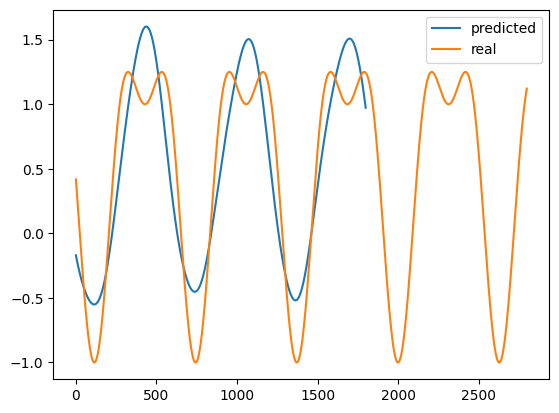

In [14]:
y_pred = forward(state_dict, jnp.expand_dims(jnp.arange(-9,9,0.01), -1))
y_true = y
from matplotlib import pyplot as plt
plt.plot(y_pred, label = "predicted")
plt.plot(y_true, label = "real")
plt.legend()
plt.show()